In [1]:
%matplotlib inline
import requests
from PIL import Image, ImageDraw,ImageFont
import face_recognition
import pandas as pd
import numpy as np
from os.path import basename
import math
import pathlib
from pathlib import Path
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


image_dir = "C:/Users/boyerm/_Capstone 3 Final/pics2"


# Hair Style Recommendation Method based on Automated Face Shape Detection

Marrnie Boyer, ThinkFul final capstone - 12/2017

With this project, I will attempt to address this challenge by developing a hairstyle recommendation system that identifies the user’s face shape and recommends the most flattering hair style. My approach will be to first build a facial classifier that will determine whether the user’s face is long, round, oval, heart- or square-shaped.  Based on the classification, the model will recommend appealing hairstyles. The recommendation system will continually update utilizing user input on their most and least desired hair styles. 

First, I want everyone to know what "face shape" means and why it is important.  For this project, I am focusing on women's faces and hair styles, although this concept applies to men too.  Face shape is often used to help women determine how to style their hair, choose their eye glasses and apply their make up.  Face shape detection is subjective and this project attempts to provide a more quantitative approach.
Good Housekeeping recognizes five main face shapes.  Below are examples of each of these shapes.

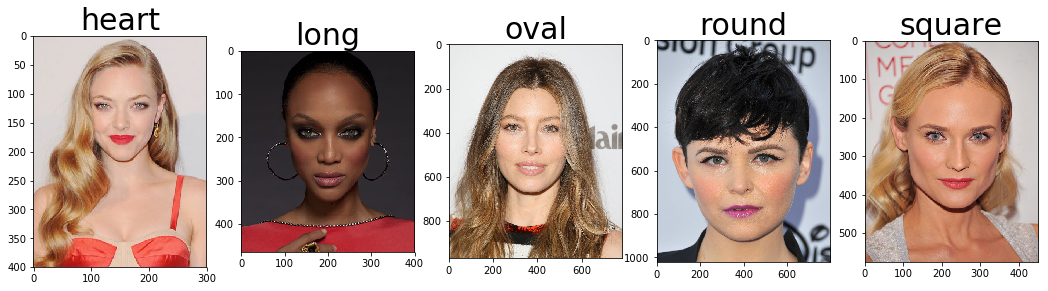

In [2]:
plt.figure(figsize = (18,18))

examples = ['C:/Users/boyerm/_Capstone 3 Final/pics/heart/amanda seyfried 10.jpg',
            'C:/Users/boyerm/_Capstone 3 Final/pics/long/Tyra Banks (4).jpg',
            'C:/Users/boyerm/_Capstone 3 Final/pics/oval/Jessica Biel (20).jpg',
            'C:/Users/boyerm/_Capstone 3 Final/pics/round/Ginnifer Goodwin (35).jpg',
            'C:/Users/boyerm/_Capstone 3 Final/pics/square/Diane Kruger (1).jpg']

names = ['heart','long','oval','round','square']
            
for i in range(0,len(examples)):
    plt.subplot(2,5,i+1)
    img = Image.open(examples[i])
    draw = ImageDraw.Draw(img)
    plt.imshow(img)
    plt.title(names[i],fontsize= 30)
    img.close()

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Dataset Collection

In order to develop a set of images labeled with the correct face shape, I turned to the experts in the fashion and style industry. I reviewed 22 websites and 234 celebrities.  Of these, 33 celebrities had a unanimous classification from 3 or more sites (65 from 2 or more). 49 other celebrities had one or two conflicting classifications but had strong consensus towards a face shape with which I could use to classify. 

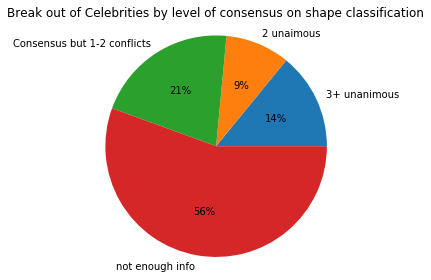

In [4]:
celeb_count = [33,22,49,130]
labels = ['3+ unanimous','2 unaimous','Consensus but 1-2 conflicts','not enough info']
patches = plt.pie(celeb_count, labels = labels,autopct='%1.f%%')
plt.axis('equal')
plt.title('Break out of Celebrities by level of consensus on shape classification')
plt.tight_layout()
plt.show()

Of the five face shapes, square faced celebrities were the most agreed upon, with 74% of those celebrities having a unanimous consensus on their shape. Round was second highest at 70%.  

Because the classification of face shape is subjective, this will impact the potential accuracy of the model, however, this model attempts to develop an approach to resolving conflict over face shape and providing more stringent guidelines on the definitions.  

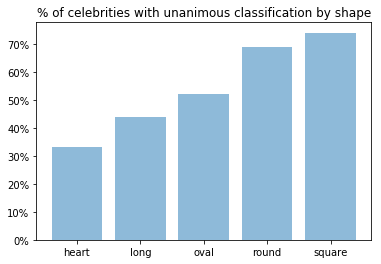

In [7]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()
formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
ax.yaxis.set_major_formatter(formatter)


percent_unanim = [33,44,52,69,74]
shapes = ['heart','long','oval','round','square']
y_pos = np.arange(len(shapes))

plt.bar(y_pos, percent_unanim, align='center', alpha=0.5)
plt.xticks(y_pos, shapes)
plt.title('% of celebrities with unanimous classification by shape')
 

plt.show()


Square faces have the most consensus which allowed for me to use the most celebrities with square faces.  

In order to collect the image dataset, a script was run to download 100 images from Google Images for each celebrity. The images were manually reviewed to ensure they will work for this project (I quickly confirmed that it was an image of celebrity's face and generally face-forward). The appropriate images were saved out to folders with the name of the classified shape. My dataset consisted of 1554 images for the 

In [8]:
# Below is the reference to the python script (I don't recommend running as it 
# will download images from Google!)

#%run -i scrape_google_images.py

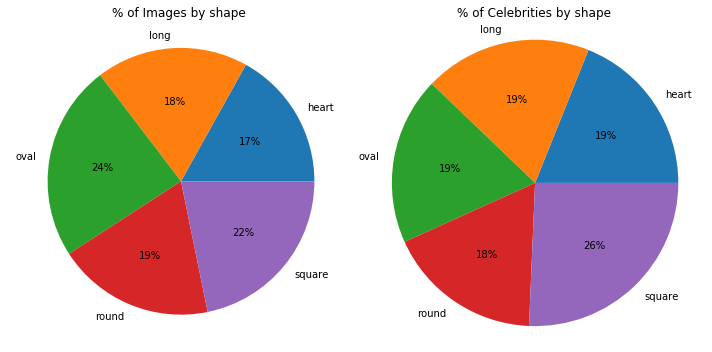

In [16]:
plt.figure(figsize=(10,5)) 
plt.subplot(1,2,1)
shape_count = data.groupby('classified_shape').count()['0']
labels = shape_count.index
patches = plt.pie(shape_count,autopct='%1.f%%', labels = labels)
plt.axis('equal')
plt.title('% of Images by shape')
plt.tight_layout()

plt.subplot(1,2,2)
celebritites_by_shape = [14,14,14,13,19]
labels = ['heart','long','oval','round','square']

patches = plt.pie(celebritites_by_shape,autopct='%1.f%%', labels = labels)
plt.axis('equal')
plt.title('% of Celebrities by shape')
plt.tight_layout()
plt.show()

# Processing Images

An extraordinary amount of work has been done around computer vision such that a library called face_recognition exists to locate the features of a human face.  This library was built using dlib’s state-of-the-art face recognition built with deep learning. 

### Feature Extraction

Below is a map of the facial feature map which generates 68 unique points.

<img src="face_points.jpg" alt="80s music" style="width: 600px;"/>

Note that the face_recognition package does not provide a top point of the head, so on the basis of a few observations, I determined the half-way point on the face is point 29, so I used double the distance between the chin and point 29 to determine face height. Another available method would be to use the change color (from skin to hair) as the top of the face, however, this would require that the photos not have any bangs and may not work for all skin/hair color combinations. 

From these face points, I developed 23 additional features.  For the first 16 features, I calculated the angles between the chin point (point 9) and each of the jaw line points (1-8, 10-17).  Additionally, I added face width (the distance from point 1 to point 17), face height (described above), the ratio between them, the jaw width (distance between points 7 and 11), the jaw width to face width ratio, the mid-jaw width (distance between points 5 and 13), and the mid-jaw width to jaw width ratio.

### Processing

In order to process over 1500 images, I developed a function that processes through the folders that I created in the data collection stage. It utilizes the folder name to hold the classification. This allows for future and on-going development.  Additional celebrities, images and face shapes could be added to this process without the need for updating the functions.

The function in the py file (make_face_df2) is the primary function for feature development. For each image, the function identifies each of the facial features utilizing face_recognition. Using the eyes as the pivot point, it rotates the face so it is facing forward. It also crops the photos so that every image has the same dimensions and the eyes are locked into the same place on each photo. The function identifies the location of the facial features using the new aligned/cropped image.

The function then calculates the features described above: the angles between the chin point (9) and all of the lower facial features (1 - 8, 10 - 17), Face Width, Face Height, the ratio of height to face,	Jaw width, the ratio of the jaw to face width, the mid-jaw width and the mid-jaw to face width.

All of these points and features are then placed into a dataframe to start analyzing with various models.

In [5]:
df = pd.DataFrame(columns = ['0','1','2','3','4','5','6','7','8','9','10','11',	'12',	'13',	'14',	'15',	'16','17',
                             '18',	'19',	'20',	'21',	'22',	'23',	'24','25',	'26',	'27',	'28',	'29',
                             '30',	'31',	'32',	'33',	'34',	'35',	'36',	'37',	'38',	'39',	'40',	'41',
                             '42',	'43',	'44',	'45',	'46',	'47',	'48',	'49',	'50',	'51',	'52',	'53',
                             '54',	'55',	'56',	'57',	'58',	'59',	'60',	'61',	'62',	'63',	'64',	'65',
                             '66',	'67',	'68',	'69',	'70',	'71',	'72',	'73',	'74',	'75',	'76',	'77',
                             '78',	'79',	'80',	'81',	'82',	'83',	'84',	'85',	'86',	'87',	'88',	'89',
                             '90',	'91',	'92',	'93',	'94',	'95',	'96',	'97',	'98',	'99',	'100',	'101',
                             '102',	'103',	'104',	'105',	'106',	'107',	'108',	'109',	'110',	'111',	'112',	'113',
                             '114',	'115',	'116',	'117',	'118',	'119',	'120',	'121',	'122',	'123',	'124',	'125',
                             '126',	'127',	'128',	'129',	'130',	'131',	'132',	'133',	'134',	'135',	'136',	'137',
                             '138',	'139',	'140',	'141',	'142',	'143','A1','A2','A3','A4','A5','A6','A7','A8','A9',
                            'A10','A11','A12','A13','A14','A15','A16','Width','Height','H_W_Ratio','Jaw_width','J_F_Ratio',
                             'MJ_width','MJ_J_width'])

In [6]:
%run -i functions_only.py    # This calls my main function 

In [7]:
%run -i functions_only-save.py    # This calls my 2nd  function  for recommender

This function will run the main function on all of the photos in the above directory.

In [ ]:
# make df to store name of shape
      
data = pd.DataFrame()
data.reset_index
shape_df = pd.DataFrame(columns = ['filenum','filename','classified_shape'])
shape_array = []
def store_features_and_classification():
    filenum = -1
    sub_dir = [q for q in pathlib.Path(image_dir).iterdir() if q.is_dir()]
    start_j = 0
    end_j = len(sub_dir)

    for j in range(start_j, end_j):
        images_dir = [p for p in pathlib.Path(sub_dir[j]).iterdir() if p.is_file()]

        for p in pathlib.Path(sub_dir[j]).iterdir():
            print(p)

            shape_array= []
            if 1 == 1:
            #for f in pathlib.Path(q).iterdir():
            #   if q.is_file():
                    face_file_name = os.path.basename(p)
                    classified_face_shape = os.path.basename(os.path.dirname(p)) 
                    filenum += 1
                    make_face_df2(p,filenum)
                    shape_array.append(filenum)
                    shape_array.append(face_file_name)  
                    shape_array.append(classified_face_shape)
                    shape_df.loc[filenum] = np.array(shape_array)
            
            
store_features_and_classification()  
data = pd.concat([df, shape_df], axis=1)

In [ ]:
# Add all faces with shape to a DATA file for model
data.to_csv('all_features5.csv')


In [ ]:
## You can use this only if the data is already in a DF:

In [8]:
# load data file
# start here
data = pd.read_csv('all_features5.csv',index_col = None)
data = data.drop('Unnamed: 0',axis = 1)
data.shape

(1516, 170)

# Visualizations

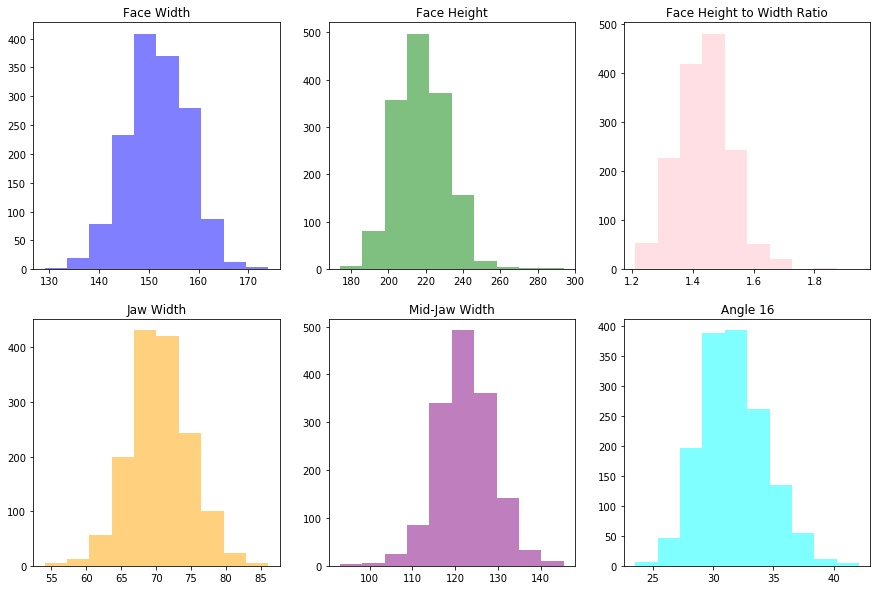

In [17]:
xclean = data.dropna(axis=0, how='any')
plt.figure(figsize=(15,10)) 

plt.subplot(2,3,1)
plt.hist(xclean['Width'], 10, facecolor='blue', alpha=0.5)
plt.title('Face Width')

plt.subplot(2,3,2)
plt.hist(xclean['Height'], 10, facecolor='green', alpha=0.5)
plt.title('Face Height')

plt.subplot(2,3,3)
plt.hist(xclean['H_W_Ratio'], 10, facecolor='pink', alpha=0.5)
plt.title('Face Height to Width Ratio')

plt.subplot(2,3,4)
plt.hist(xclean['Jaw_width'], 10, facecolor='orange', alpha=0.5)
plt.title('Jaw Width')

plt.subplot(2,3,5)
plt.hist(xclean['MJ_width'], 10, facecolor='purple', alpha=0.5)
plt.title('Mid-Jaw Width')

plt.subplot(2,3,6)
plt.hist(xclean['A16'], 10, facecolor='aqua', alpha=0.5)
plt.title('Angle 16')

plt.show()

The attributes here appear to be normally distributed. Now I want to look at the distribution by face shape and what may make them different.

In [18]:
from scipy import stats
for i in range(0,4):
    for j in range(0,4):
        t = (stats.ttest_ind(xclean[xclean.classified_shape == labels[i] ].Width, xclean[xclean.classified_shape == labels[j+1]].Width))
        print('t-test: p-value for face width between %s and %s is %s' % (labels[i],labels[j+1],t.pvalue))

t-test: p-value for face width between heart and long is 3.00101692721e-05
t-test: p-value for face width between heart and oval is 0.680885217372
t-test: p-value for face width between heart and round is 1.05204712718e-05
t-test: p-value for face width between heart and square is 0.0924650225792
t-test: p-value for face width between long and long is 1.0
t-test: p-value for face width between long and oval is 4.76707259541e-06
t-test: p-value for face width between long and round is 5.26608053662e-17
t-test: p-value for face width between long and square is 0.0156143777911
t-test: p-value for face width between oval and long is 4.76707259541e-06
t-test: p-value for face width between oval and oval is 1.0
t-test: p-value for face width between oval and round is 4.87600375303e-05
t-test: p-value for face width between oval and square is 0.031634956774
t-test: p-value for face width between round and long is 5.26608053662e-17
t-test: p-value for face width between round and oval is 4.876

Based on these t-test p-values, we can reject the null hypothesis for the following pairs (using p < 0.05):

Heart & Long faces
Heart & Round faces
Long & Oval faces
Long & Round faces
Long & Square faces
Oval & Round faces
Oval & Square faces
Round & Square faces

We cannot reject the null hypothesis for Heart & Oval (p value = 0.68) and Heart & Square (p value = 0.09)

To illustrate the tests above, below is one plot with a pair that is NOT significantly significantly different and the second one is.


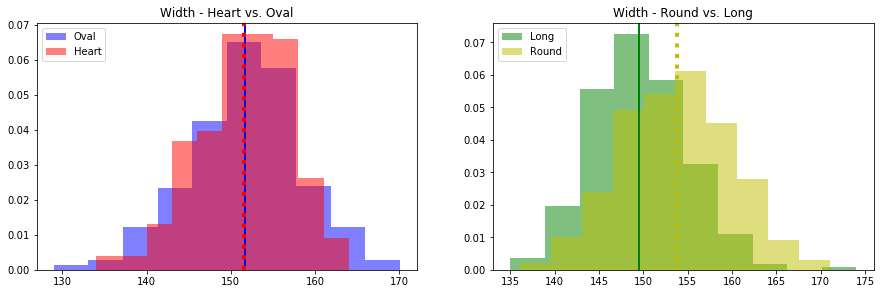

In [33]:

# Face width histograms; purposely normed because of varying sample sizes.

HW = xclean[xclean['classified_shape']=="heart"] 
OW = xclean[xclean['classified_shape']=="oval"] 
LW = xclean[xclean['classified_shape']=="long"] 
RW = xclean[xclean['classified_shape']=="round"] 

plt.figure(figsize=(15,10)) 

plt.subplot(2,2,1)
plt.hist(OW['Width'],label = 'Oval',alpha = 0.5, color = 'b',normed = True)
plt.hist(HW['Width'],label = 'Heart',alpha = 0.5, color = 'r',normed = True)
plt.axvline(OW['Width'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(HW['Width'].mean(), color='r', linestyle='dotted', linewidth=4)
plt.title('Width - Heart vs. Oval')
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.hist(LW['Width'],label = 'Long',alpha = 0.5, color = 'g',normed = True)
plt.hist(RW['Width'],label = 'Round',alpha = 0.5, color = 'y',normed = True)
plt.axvline(LW['Width'].mean(), color='g', linestyle='solid', linewidth=2)
plt.axvline(RW['Width'].mean(), color='y', linestyle='dotted', linewidth=4)
plt.legend(loc='upper left')
plt.title('Width - Round vs. Long')

plt.show()

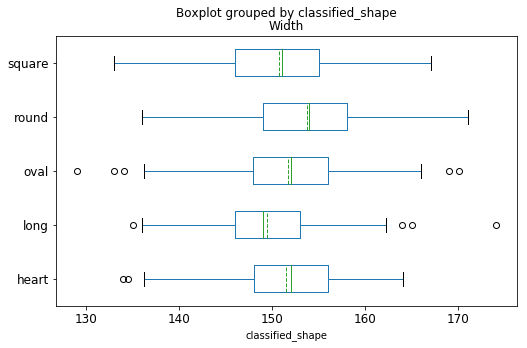

In [11]:
data.boxplot(column='Width', by='classified_shape',vert=False, ax=None, fontsize=12, rot=0, grid=False, figsize=(8,5), 
             meanline = True, showmeans = True,
                  layout=None, return_type=None)
plt.show()

Above, you will find a graph that provides the median (solid line), mean (dotted), quartiles and range of the facial widths (defined as the difference between point 1 and point 17, essentially, ear-to-ear) by facial shape.  As expected, round faces have the largest facial width median, mean and max. Long faces are characterized by having the most narrow face.

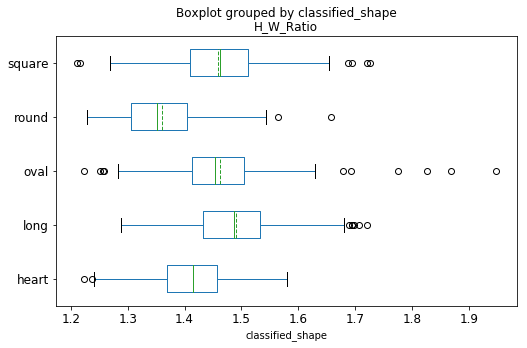

In [12]:
# H_W_Ratio

data.boxplot(column='H_W_Ratio', by='classified_shape',vert=False, ax=None, fontsize=12, rot=0, grid=False, figsize=(8,5), 
                  layout=None, return_type=None, meanline = True, showmeans = True)
plt.show()

The box plot above illustrates the face height to width ratio.  The round face shape has the lowest height to width ratio which aligns with expectations.  Square faces should also have a lower (close to 1) height to width ratio to live up to their name but that is not the case. I believe this is because the 'square' moniker is more about the woman's jaw shape than the overall face dimensions.  The oval face has the most variability for the height to width ratio attribute.

Based on my observation, face shapes really begin to vary near the mouth/chin.  Therefore, I calculated two new features regarding the width of the jaw at different locations.
The Jaw Width is defined as the distance between points 7 and 11. The Mid-jaw width is defined as the distance between the 5 and 13 points. I then calculated the ratio of those two widths.

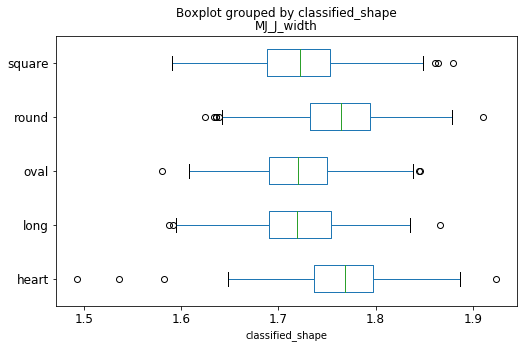

In [34]:
data.boxplot(column='MJ_J_width', by='classified_shape',vert=False, ax=None, fontsize=12, rot=0, grid=False, figsize=(8,5), 
                  layout=None, return_type=None)
plt.show()
#note this is the Mid-jaw to Jaw width ratio...

This ratio allows us to observe the narrowing between the mid jaw and jaw for the heart shaped faces, evidenced by the higher ratio.  

## Make smiley

In [9]:
face_pt_avg = data.groupby("classified_shape").mean()

face_pt_avg = face_pt_avg.drop(['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12',
                                'A13','A14','A15','A16','Width','Height','H_W_Ratio','Jaw_width','J_F_Ratio',
                                'MJ_width','MJ_J_width'],axis = 1)


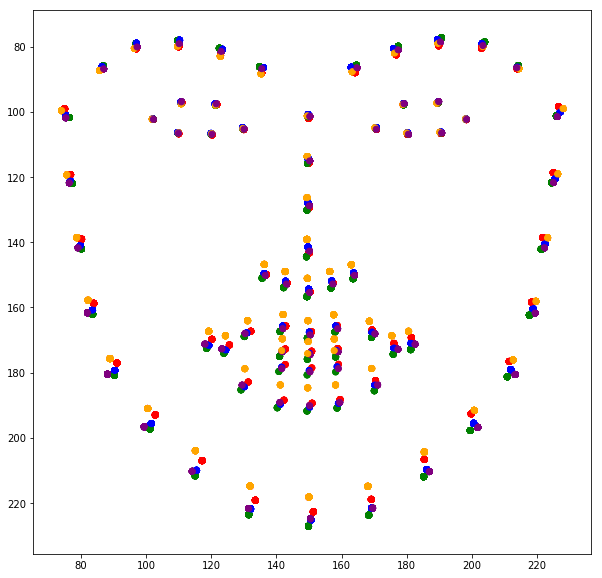

In [49]:
feature_ct = (face_pt_avg.shape[1])/2
feature_ct = int(feature_ct)
colors = ('red','green','blue','orange','purple')
labels =  ('heart','long','oval','round','square')
plt.figure(figsize = (10,10))

def make_smiley(x,rs,re):
    x_arr = []
    y_arr = []

    for ff in range(0, feature_ct):
        fpav = face_pt_avg.values
        x_coord = fpav[rs:re,x:x+1]
        y_coord = fpav[rs:re,x+1:x+2]
        x_arr.append(x_coord)
        y_arr.append(y_coord)
        x += 2

        plt.scatter(x_arr,y_arr,c=colors,label = labels ) 
        
    
    plt.gca().invert_yaxis()

    plt.show()

x = 0
rs = 0
re = 6
make_smiley(x,rs,re) 

### NEED TO MAKE LEGEND! ####

## Face Overlays

The following images illustrate how the crop/align/rotate process allows for the faces to be very consistent in their position within the frame. This was an important step because the photos were taken by all different photographers, at different times and from multiple positions.  Without this step to standardize, there was a lot more noise in the derived and calculated  features.

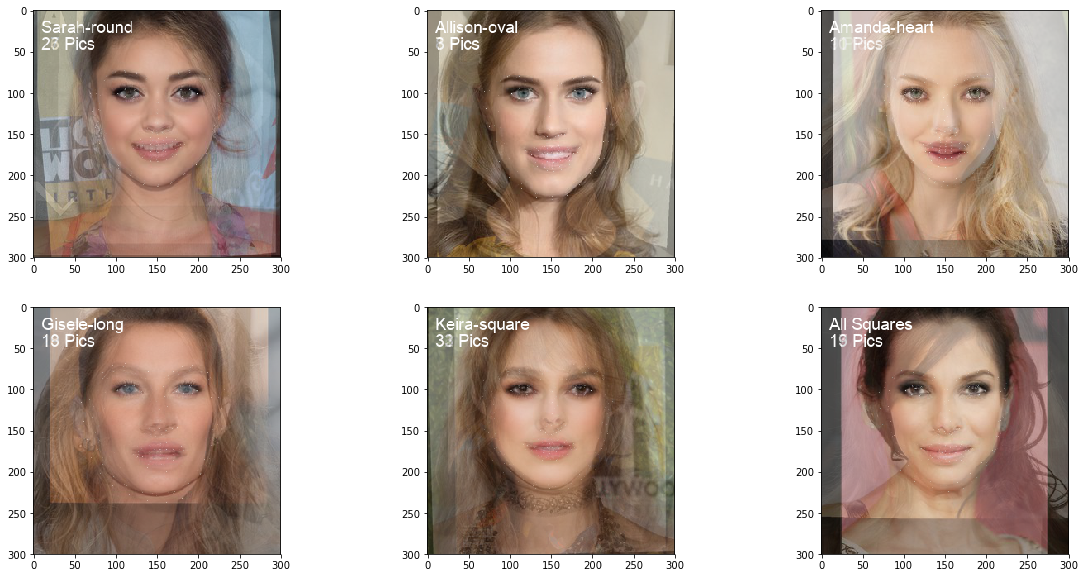

In [16]:
%run -i Plot_Images.py 

# Evaluate models

Based the limited amount of data for training, it is not unexpected that the models performance will show both over-training and lower accuracy than if I had thousands or millions of sample images.  There are no guidelines or real ground-truth for classification of facial shapes.  This is what makes this project interesting but challenging.  Keeping this in mind, I worked to develop the best model possible.

## Modeling Pipeline

The process I utilized to build my model is to begin with capturing the data as described above, then I scaled the data by removing the mean and scaling to unit variance.  This is done so that each feature contributes approximately proportionately to the model.  I then generate new features as described above.  I attempted to extract features using PCA but that process did not significantly improve the speed and/or results of my models. Although PCA was able to slightly improve overfitting.

The scaled inputs were split into train/test and then proessed through the models below.

## Model Comparisons

Refer to the notebook below for the models I decided not to use.  

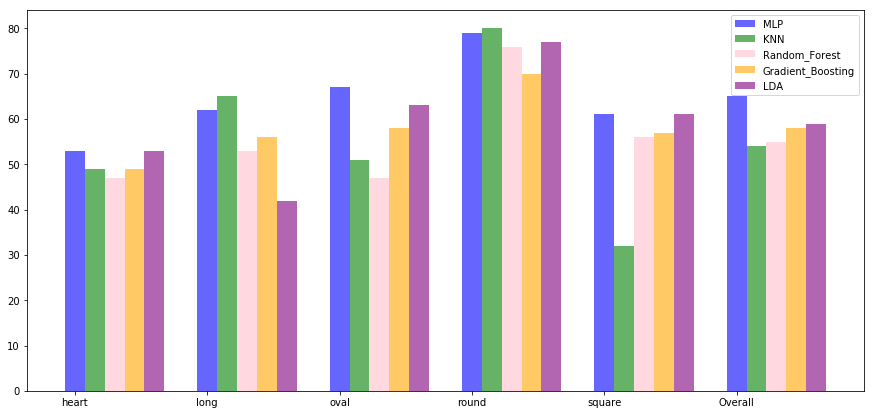

In [38]:
% run -i model_comparisons.py

In model_comparisons.py, I evaluated each model that I built. For each model, I calculated the recall for each face shape as well as the overall model. I chose MLP neural network model because it performed the best in 4 out of 5 classifications and overall. I also believe this model will continue to improve performance as more images are added, which will allow the application to scale efficiently.

The neural network model performed well but I know it would be a much better model with many more input images and celebrities.  All of the models had over-fitting, likely because of the use of the same celebrity in many images. I attempted to use PCA to reduce the variables.  

### Retraining a CNN Model

I also ventured to retrain an convolutional neural network with Keras to take advantage of its significant accuracy in detecting images. Without the proper equipment (and experience), this proved to be a difficult task.  It serves as a motivator for future development.  The process I utilized was to import a CNN from the Keras Application library, then remove its 'top' layer (the 1-1 classification layer), and retrain it on my images and classifications. After 50 epochs, the accuracy was only 35%. I could do more epochs, but this process takes a long time on my PC (about 30 min per epoch!)

## Supervised Learning - the chosen model

### Set up Test/Train for supervised learning

In [20]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import ensemble
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA 

In [21]:
data_clean = data.dropna(axis=0, how='any')
X = data_clean
X = X.drop(['filenum','filename','classified_shape'] , axis = 1)
X_norm = normalize(X)
Y = data_clean['classified_shape']

### Standardize features by removing the mean and scaling to unit variance

In [22]:
scaler = StandardScaler()  
scaler.fit(X)  

X = scaler.transform(X)

### Split into train/test sets

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=0.25,
    random_state=None)

### Apply PCA for dimension reduction

In [24]:
n_components = 18
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [25]:
# #Remove PCA 

X_train_pca = X_train
X_test_pca = X_test

## Neural Network (MLP)

In [26]:
mlp = MLPClassifier(hidden_layer_sizes=(60,10,60,30), solver='sgd',shuffle  = True, 
                    learning_rate_init=0.01, max_iter = 1000,warm_start  = False)
#reducing the learning rate init allowed the MLP to converge 
mlp.fit(X_train_pca, Y_train)
mlp.score(X_train_pca, Y_train)

mlp.score(X_train_pca,Y_train)

mlp_score = mlp.score(X_test_pca,Y_test)
print(mlp_score)

y_pred = mlp.predict(X_test_pca)
 
mlp_crosstab = pd.crosstab(Y_test, y_pred, margins=True)
mlp_crosstab


from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X, Y, cv=5)

print(classification_report(Y_test,y_pred))


0.641711229947
             precision    recall  f1-score   support

      heart       0.49      0.54      0.52        57
       long       0.75      0.58      0.65        78
       oval       0.59      0.55      0.57        89
      round       0.72      0.77      0.75        78
     square       0.65      0.76      0.70        72

avg / total       0.65      0.64      0.64       374



# Run Example:

This section is the implementation of the model itself on a new image.  Select a photo and start the process below.

In [42]:
my_photo = 'jackie.jpg'
n = 2035
make_face_df2_save(my_photo,n)

In [43]:
dfc = df
test_row = dfc.ix[n].values.reshape(1,-1)
test_row = scaler.transform(test_row)  
test_shape = mlp.predict(test_row)
print(test_shape)

['square']


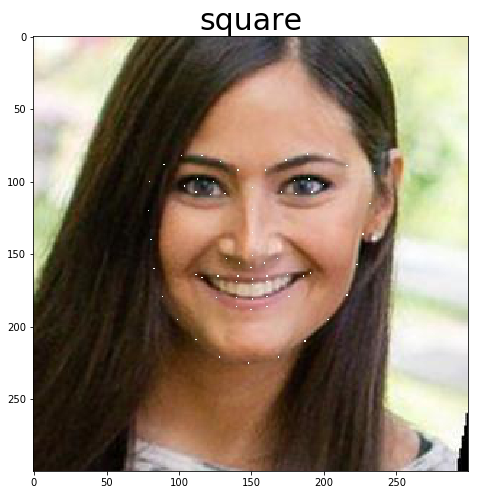

In [44]:
plt.figure(figsize = (8,8))
new_photo = my_photo+'_NEW_rotated_pts.jpg'
img = Image.open(new_photo)
draw = ImageDraw.Draw(img)
plt.title(test_shape[0], fontsize = 30)
plt.imshow(img)
img.close()

In [19]:
dfc

,0,1,2,3,4,5,6,7,8,9,...,A14,A15,A16,Width,Height,H_W_Ratio,Jaw_width,J_F_Ratio,MJ_width,MJ_J_width
2035,65.0,103.0,64.0,124.0,64.0,146.0,67.0,168.0,77.0,186.0,...,34.862196,30.884945,27.299572,146.054784,228.560714,1.564897,68.264193,0.467388,123.199026,1.804739


# Recommender

The recommender python file below contains the code for the recommender which uses as inputs: the face shape classified above, the user's desire for an up-do or not and their hair length.

It returns 6 images of hair styles recommended for their face shape.  The original selection is based on a random number score. However, the user can then provide feedback to the system that indicates their top and bottom preference.  This preference iterates back into the score by adding or removing points from the score.  If the user liked the style, this will increase the priority of the style for the next user and the opposite is true for the user's least favorite style.  This is a rudimentary system but utilized as a basic concept.

The recommender images are a subset of the images I used to train the model.  I reduced to a subset to remove having too many of the same hairstyles, especially from the same celebrity as well as very outdated hair style

In [45]:
% run -i recommender.py

In [46]:
print(test_shape)

['square']


What is your name? Marnie
Hello, Marnie.
Would you like to see up-dos? (Y/N)N
Is your hair short (shoulder-length shorter) or long?Long
Long


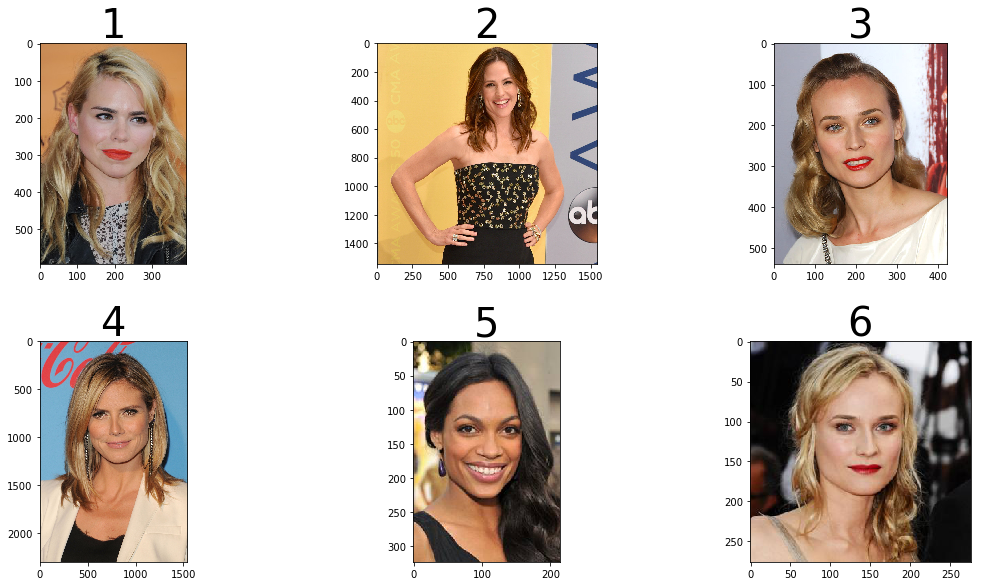

Which style is your favorite?2
Which file is your least favorite6


In [47]:
run_recommender(test_shape)


What is your name? Marnie
Hello, Marnie.
Would you like to see up-dos? (Y/N)N
Is your hair short (shoulder-length shorter) or long?Long
Long


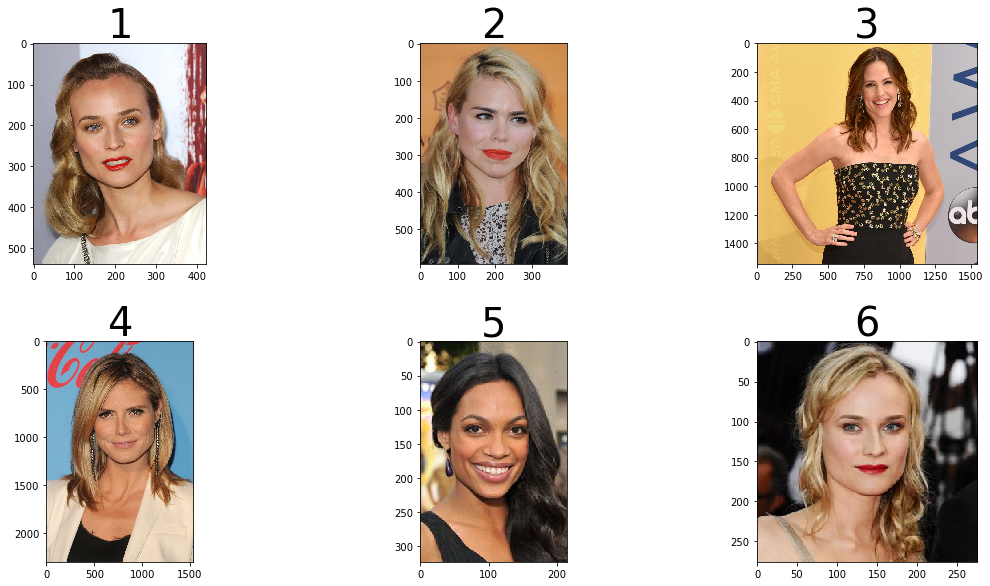

Which style is your favorite?
Which file is your least favorite


In [48]:
run_recommender(test_shape)

What is your name? m
Hello, m.
Would you like to see up-dos? (Y/N)n
Is your hair short (shoulder-length shorter) or long?long
Long


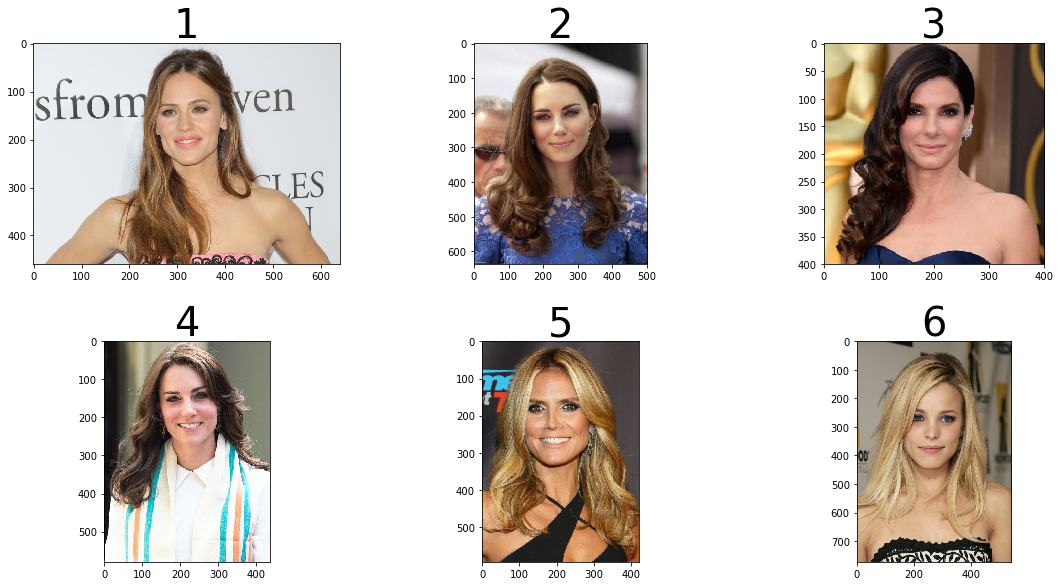

In [ ]:
run_recommender(test_shape)